# Covid determination

## Description

### Task

Need to create ML model for determination Covid-19 using Temperature, O2 saturation and Pressure.

Synthetic data will be used for teaching ML models.
Non synthetic data will be used for testing the best model.

**Metrics:**

   - main metrics - Accuracy
   - additional metrics - F1 score

**Dataset contains:**
   - temerature
   - O2 saturation
   - pulse rate

**Data sourse:** 
   - www.kaggle.com - for synthetic data
   - https://zenodo.org/record/4766192 - for non synthetic data

## 0. Importing libraries and adding constants

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix, recall_score, f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import shap
import time


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
RS = 12345 # random state

## 1. Getting to know the data

In [3]:
df = pd.read_csv ('/Users/dmitry/Desktop/python/covir prediction (T,O2,p)/qt_dataset.csv',
                  encoding='windows-1252')
display(df)

,ID,Oxygen,PulseRate,Temperature,Result
0,0,98.0,65.0,95.0,Negative
1,1,96.0,92.0,95.0,Negative
2,2,95.0,92.0,99.0,Negative
3,3,97.0,56.0,96.0,Negative
4,4,88.0,94.0,98.0,Positive
...,...,...,...,...,...
9997,9997,99.0,56.0,105.0,Negative
9998,9998,92.0,49.0,98.0,Positive
9999,9999,85.0,52.0,99.0,Positive
10000,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.head(10000)
df = df.drop('ID', axis = 1)
display(df)

,Oxygen,PulseRate,Temperature,Result
0,98.0,65.0,95.0,Negative
1,96.0,92.0,95.0,Negative
2,95.0,92.0,99.0,Negative
3,97.0,56.0,96.0,Negative
4,88.0,94.0,98.0,Positive
...,...,...,...,...
9995,95.0,124.0,97.0,Negative
9996,88.0,70.0,100.0,Positive
9997,99.0,56.0,105.0,Negative
9998,92.0,49.0,98.0,Positive


In [5]:
initial_len = len(df)
df=df.drop_duplicates(keep = 'first')
final_len = len(df)
print(f'{round(100*(1-final_len/initial_len),1)}% or {initial_len - final_len} / {initial_len} rows of dataset have reduced by deduplication')

26.1% or 2608 / 10000 rows of dataset have reduced by deduplication


In [6]:
positive_fraction = round(100*len(df.loc[df['Result'] == 'Positive']) / len(df),2)
negative_fraction = round(100*len(df.loc[df['Result'] == 'Negative']) / len(df),2)

print (f'Positive fraction in current dataset is {positive_fraction}%')
print (f'Negative fraction in current dataset is {negative_fraction}%')



Positive fraction in current dataset is 50.31%
Negative fraction in current dataset is 49.69%


The figure layout has changed to tight


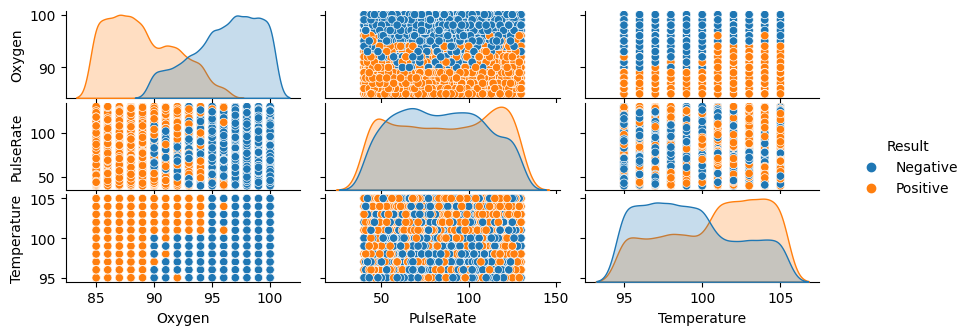

In [7]:
sns.pairplot(df, hue = 'Result')
plt.gcf().set_size_inches(10,3)


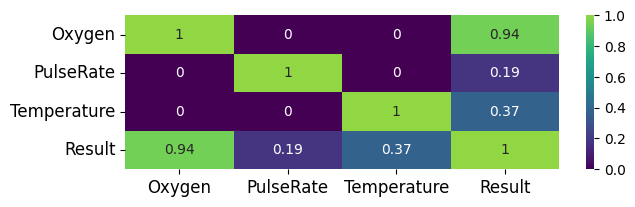

In [8]:
phik_m = df.phik_matrix(interval_cols = ['Oxygen', 'PulseRate', 'Temperature'])

plt.figure(figsize=(7,2))
sns.heatmap(phik_m,
            xticklabels=phik_m.columns,
            yticklabels=phik_m.columns,
            cmap='viridis',
            center=0.6,
            annot=True)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

##### Findings:

1. Dataset contain 10000 rows without 'NaN' values
2. 26.1% or 2608 / 10000 rows of dataset have reduced by deduplication.
3. Datasets has good balance between positive and negative results (49.69% and 50.31%)
4. Pairploting shows greate differance of O2 saturation and medium difference of temperature for 'positine' and 'negative' Covid results. It is corresponds to correlation matrix for the dataset.
5. Correlation between result:
  - 94% between result and O2 saturation
  - 37% between result and temperature
  - 19% between result and pulse rate
6. Pair correlations between three parameter (O2 saturation, pulse rate and temperature) are really low (<0.5%).
7. Point №5 and №6 together indicates that cavid determination requires all three parameters for better forecast.

## 2. Preparing datasets for teaching ML models

### Initial dataset separation

Before separation initial dataset we should perlace column 'Result' on '1' (positive results) and '0' (negative results). It is neded for using different ML models.

In [9]:
df = df.replace({'Result': 'Positive'}, 1)
df = df.replace({'Result': 'Negative'}, 0)
df.head()

,Oxygen,PulseRate,Temperature,Result
0,98.0,65.0,95.0,0
1,96.0,92.0,95.0,0
2,95.0,92.0,99.0,0
3,97.0,56.0,96.0,0
4,88.0,94.0,98.0,1


We will use crossvalidation method for teaching ML model, thus we shoud separate initial dataset only for train and test datasets.

In [10]:
features = df.drop('Result', axis = 1)
target = df['Result']
(f_train, f_test, t_train, t_test) = train_test_split(features, target, test_size = 0.25, random_state = RS)

print('features_train:', f_train.shape)
print('target_train:', t_train.shape)

print('features_train:', f_test.shape)
print('target_train:', t_test.shape)

features_train: (5544, 3)
target_train: (5544,)
features_train: (1848, 3)
target_train: (1848,)


Let's make shure that we have balanced train and test datasets

In [11]:
print(f'Positive share in train dataset = {round(100*t_train.mean(),2)}%')
print(f'Positive share in test dataset  = {round(100*t_test.mean(),2)}%')

Positive share in train dataset = 50.85%
Positive share in test dataset  = 48.7%


### Datasets normalizations

We will use StandardScaler from sklearn.preprocessing for normalisation data.

In [12]:
col = list(f_train)

scaler = StandardScaler()
scaler.fit(f_train[col])

f_train[col] = scaler.transform(f_train[col])
f_test[col]  = scaler.transform(f_test[col])

In [13]:
print('feature train dataframe:')
display(f_train.head())
print('\nfeature test dataframe:')
display(f_test.head())

feature train dataframe:


,Oxygen,PulseRate,Temperature
4716,-0.541459,0.904294,-0.941737
3242,-0.541459,-0.346357,0.001191
870,1.626411,-0.535850,-0.941737
6854,1.192837,0.070527,-0.627428
4736,1.626411,0.525309,1.572736



feature test dataframe:


,Oxygen,PulseRate,Temperature
3204,-0.975033,-1.331719,0.001191
3681,1.409624,0.714802,1.258427
64,-0.758246,0.828497,0.001191
121,0.976050,0.904294,-0.313119
7632,1.409624,0.487410,-1.256046


## Teaching ML models

Functions for teaching model and calculation metrics

In [14]:
def metrics (model_gs, features, target, timer):
    
    try:
        start_time = time.time()
        prediction = model_gs.predict(features)
        end_time = time.time()
        
        if timer == 1:
            result = [round(recall_score(target, prediction),3),
                      round(f1_score(target, prediction),3),
                      round(end_time - start_time,3)]
            columns = ['Accuracy',
                       'F1 score',
                       'Prediction time per event, s']
        else:
            result = [round(recall_score(target, prediction),3),
                      round(f1_score(target, prediction),3)]
            columns = ['Accuracy',
                       'F1 score']

        
        df = pd.DataFrame(data = [result], columns = columns)
        conf_matrix= pd.DataFrame(data = confusion_matrix(target, prediction),
                                  columns = ['0', '1'],
                                  index = ['0', '1'])

        print('Confusion matrix:')
        display(conf_matrix)
        display(df)

        return(df, confusion_matrix (target, prediction))
    
    except:
        print('Error, please chech parameters and fuction')
        return (0,0)

In [15]:
def teaching_model(model, grid_space, main_scoring, dataset_type):
    
    try:
        grid = GridSearchCV(model,
                            param_grid = grid_space,
                            cv = 10,
                            scoring = main_scoring,
                            n_jobs = 6
                           )

        model_gs = grid.fit(f_train, t_train)
        print('Best parameters:')
        display(model_gs.best_params_)
        
        
        if dataset_type == 'train':
            f_dataset = f_train
            t_dataset = t_train
        elif dataset_type == 'test':
            f_dataset = f_test
            t_dataset = t_test
        else:
            print('Error, please chech parameters "dataset_type"')

        result, conf_matrix = metrics (model_gs, f_dataset, t_dataset, 1)
        return model_gs, result, model_gs.best_params_
            
    except:
        print('Error, please chech parameters and fuctions1')
        return (0,0,0)

### Model: LogisticRegression

In [16]:
grid_space = {'C': [100, 200, 300, 500, 1000, 2000, 3000, 5000]}
model = LogisticRegression(solver = 'liblinear', random_state = RS)

model_lr, result_lr, param_lr = teaching_model (model, grid_space, 'accuracy', 'train')

Best parameters:


{'C': 100}

Confusion matrix:


,0,1
0,2510,215
1,220,2599


,Accuracy,F1 score,"Prediction time per event, s"
0,0.922,0.923,0.011


### Model: RandomForestClassifier

In [17]:
grid_space = {'n_estimators':[10, 20, 50, 100, 200],
              'max_depth':range(2,10)}

model = RandomForestClassifier(random_state = RS)
model_rf, result_rf, param_rf = teaching_model (model, grid_space, 'accuracy', 'train')

Best parameters:


{'max_depth': 7, 'n_estimators': 100}

Confusion matrix:


,0,1
0,2725,0
1,0,2819


,Accuracy,F1 score,"Prediction time per event, s"
0,1.0,1.0,0.024


### Model: LGBMClassifier

In [18]:
grid_space = {'n_estimators': [50,100,300,500],
              'max_depth' : [5,10],
              'num_leaves': [5,10,20],
              'learning_rate': [0.1,0.2,0.3, 0.5]}
model = lgb.LGBMClassifier(random_state = RS)

model_lgbm, result_lgbm, param_lgbm = teaching_model (model, grid_space, 'accuracy', 'train')

Best parameters:


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 5}

Confusion matrix:


,0,1
0,2725,0
1,0,2819


,Accuracy,F1 score,"Prediction time per event, s"
0,1.0,1.0,0.003


### Result for all teached models

In [19]:
result_df = pd.concat([result_lr, result_rf, result_lgbm], ignore_index=True)
result_df.index = ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier']

display(result_df)

,Accuracy,F1 score,"Prediction time per event, s"
LogisticRegression,0.922,0.923,0.011
RandomForestClassifier,1.000,1.000,0.024
LGBMClassifier,1.000,1.000,0.003


Let's see the influence of dataset parametes on result for model "LGBMClassifier":

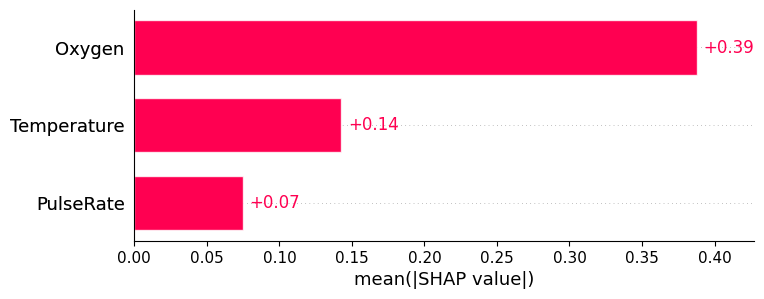

In [20]:
explainer = shap.Explainer(model_lgbm.predict, f_train)
shap_values = explainer(f_train)

shap.plots.bar(shap_values)

#### Findings
1. RandomForestClassifier and LGBMClassifier shows best result and classified correctly all data.
2. LGBMClassifier has best prediction that RandomForestClassifier (0.002 mcs vs 0.015 s)
3. Tace into accaunt all three metrics (Accuracy, F1 score and Prediction time) Models LGBMClassifider seems the best model among all three models.
4. Also model LGBMClassifier has less parameters 'max_depth' that RandomForestClassifier. It indicates less probabilities to get an overtrained model.
5. O2 saturation has greater influence on Covic determination:
   - 0.39 - O2 saturation
   - 0.14 - Tmperature
   - 0.07 - PulseRate
   
   Which corresponds to correlation matrix (phik_matrix).

## 3. Testing the best model (LGBMClassifier) using test dataset

In [21]:
print('Determined metrics for model LGBMClassifier on test data:\n')
result = metrics (model_lgbm, f_test, t_test, 0)


Determined metrics for model LGBMClassifier on test data:

Confusion matrix:


,0,1
0,948,0
1,0,900


,Accuracy,F1 score
0,1.0,1.0


## 4. Testing the best model (LGBMClassifier) using non synthetic dataset

### Adding and getting to know the dataset with non synthetic data


In [22]:
df2 = pd.read_csv ('/Users/dmitry/Downloads/covid-19-26.csv')
display(df2.head())
df2.info()

,id,gender,age,heart_rate,temperature,SpO2_saturation,bpm,Health_status
0,1,male,66.0,70,38.6,88.0,75,Infected
1,2,female,56.0,74,39.6,88.0,70,Infected
2,3,male,46.0,82,37.2,98.0,83,Non Infected
3,4,female,60.0,90,38.6,98.0,75,Non Infected
4,5,male,58.0,72,39.6,93.0,78,Infected


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1085 non-null   int64  
 1   gender           902 non-null    object 
 2   age              843 non-null    float64
 3   heart_rate       1085 non-null   int64  
 4   temperature      1085 non-null   float64
 5   SpO2_saturation  1085 non-null   float64
 6   bpm              1085 non-null   int64  
 7   Health_status    1085 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 67.9+ KB


### Checking deduplication

In [23]:
initial_len = len(df2)
df2 = df2.drop_duplicates(keep = 'first')
final_len = len(df2)
print(f'{round(100*(1-final_len/initial_len),1)}% or {initial_len - final_len} / {initial_len} rows of dataset have reduced by deduplication')

0.0% or 0 / 1085 rows of dataset have reduced by deduplication


### Replacing 'Health_status' on '1' (infected) ans '0' (non infected)

In [24]:
df2['Health_status'].unique()

array(['Infected', 'Non Infected', 'Non infected ', 'Non infected'],
      dtype=object)

In [25]:
df2['Health_status'] = df2['Health_status'].replace('Infected',1)
df2['Health_status'] = df2['Health_status'].replace('Non Infected',0)
df2['Health_status'] = df2['Health_status'].replace('Non infected ',0)
df2['Health_status'] = df2['Health_status'].replace('Non infected',0)

df2['Health_status'] = pd.to_numeric(df2['Health_status'], errors="coerce")

display(df2.head())
df2.info()

,id,gender,age,heart_rate,temperature,SpO2_saturation,bpm,Health_status
0,1,male,66.0,70,38.6,88.0,75,1
1,2,female,56.0,74,39.6,88.0,70,1
2,3,male,46.0,82,37.2,98.0,83,0
3,4,female,60.0,90,38.6,98.0,75,0
4,5,male,58.0,72,39.6,93.0,78,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1085 non-null   int64  
 1   gender           902 non-null    object 
 2   age              843 non-null    float64
 3   heart_rate       1085 non-null   int64  
 4   temperature      1085 non-null   float64
 5   SpO2_saturation  1085 non-null   float64
 6   bpm              1085 non-null   int64  
 7   Health_status    1085 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 67.9+ KB


### Creating feature dataset and target dataset for checking LGBMClassifier model 

In [26]:
df2['Oxygen'] = df2['SpO2_saturation']
df2['PulseRate'] = df2['heart_rate']
df2['Temperature'] = df2['temperature']

f_real = pd.DataFrame()
f_real['Oxygen'] = df2['SpO2_saturation']
f_real['PulseRate'] = df2['heart_rate']
f_real['Temperature'] = df2['temperature']

col = list(f_train)
f_real[col] = scaler.transform(f_real[col])

t_real = df2['Health_status']

print('Feature dataset:')
display (f_real.head())

print('\nTarget dataset:')
display (t_real.head())

Feature dataset:


,Oxygen,PulseRate,Temperature
0,-0.975033,-0.573748,-19.297388
1,-0.975033,-0.422154,-18.983079
2,1.192837,-0.118966,-19.737421
3,1.192837,0.184222,-19.297388
4,0.108902,-0.497951,-18.983079



Target dataset:


0    1
1    1
2    0
3    0
4    1
Name: Health_status, dtype: int64

### Checking teached LGBMClassifier model

In [27]:
print('Determined metrics for model LGBMClassifier on non synthetic data:\n')
result = metrics (model_lgbm, f_real, t_real, 0)

Determined metrics for model LGBMClassifier on non synthetic data:

Confusion matrix:


,0,1
0,127,13
1,91,854


,Accuracy,F1 score
0,0.904,0.943


## 5. Conclusion